In [21]:
%pylab inline --no-import-all
import matplotlib.ticker as ticker
import matplotlib.cm as cmap

import math
import numpy as np
import scipy.stats as ss
import scipy.special as ssp

from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt


import george
from meanAndKernel import Mean, Kernel

Populating the interactive namespace from numpy and matplotlib


### We want to smooth our data to create toys for our tests. We use a Gaussian kernel that is of order the bin width of the distribution to smear out the data. For this, we need out data extended a bit below the minimum in order to accurately smear the lower mass end.

#### Load inputs: extended distribution to smear = "truth". xbins_smeared is the binning of your distribution - where you want your toys binned.

In [22]:
xbins_truth = np.load("inputs/xbins_fullRange.npy")
xerrs_truth=np.load("inputs/xerrs_fullRange.npy")
ycounts_truth = np.load("inputs/ycounts_fullRange.npy")
yerrs_truth = np.load("inputs/yerrs_fullRange.npy")

xbins_smeared = np.load("inputs/xbins.npy")
xerrs_smeared = np.load("inputs/xerrs.npy")
binEdges = list(np.load("inputs/binedges.npy"))
fixedHyperparameters = np.load("inputs/fixedHyperparameters.npy")

startingCut = 1100
start_bin = np.argmax(xbins_truth > startingCut)

In [23]:
Amp, lengthscale, p0, p1, p2 = fixedHyperparameters

#### Plots
* plot_truth = Plot truth, smeared, and noisy smeared distributions
* plot_GP = Plot smeared, noisy, and Gaussian Process distributions with $1\sigma$ error on the Gaussian Process


In [24]:
def plot_truth(smeared, noisy, truth):
    plt.figure(figsize(10,8))
    plt.ylabel('Events', fontsize=20)
    plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)

    plt.plot(xbins_smeared,smeared, c='crimson', linewidth=3, alpha=0.5,label="smeared distribution")
    plt.errorbar(xbins_smeared,noisy, yerr=np.sqrt(noisy), markersize = '3', marker='o', ls='None', c='black', label="smeared MC samples")
    plt.plot(xbins_truth, truth, c='goldenrod', linewidth=3, alpha=0.5, label="truth distribution")
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([0.1, 10e5])
    plt.xlim([1000,10000])

In [25]:
def plot_GP(smeared, noisy, GPmean, GPstd):
    plt.figure(figsize(10,8))
    plt.ylabel('Events', fontsize=20)
    plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
    plt.xlim([1000,10000])
    plt.ylim([0.1, 10e5])
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.xscale('log')
    plt.yscale('log')

    plt.plot(xbins_smeared, smeared, c='crimson', linewidth=3, label='smeared distribution')
    plt.plot(xbins_smeared, GPmean, c='b', linewidth=3, label="GP")
    plt.fill_between(xbins_smeared, GPmean-GPstd, GPmean+GPstd, facecolor='cornflowerblue', alpha=0.5, label=r"GP $1\sigma$ error")
    plt.errorbar(xbins_smeared,noisy, yerr=np.sqrt(noisy), marker='o', markersize='3', ls='None', c='black', label="smeared MC samples")
    plt.legend()

#### Calculate chi2 and z values. Then, make a pretty plot comparing the smoothed distribution and the original

In [26]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
               
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB))
    return zvals, chi2

def makePrettyPlots(xs, ys, bkgs, title, xlow=binEdges, col = 'g', ymax = 2e6):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    sigHist = Hist(xlow,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: sigHist[x] = 20
        else: sigHist[x] = zvals[x]  

    
    sigHist.fillstyle = 'solid'
    if col == 'g':
         sigHist.fillcolor = 'green'
    elif col == 'b':
         sigHist.fillcolor = 'blue'
    elif col == 'r':
         sigHist.fillcolor = 'red'
    else:
        sigHist.fillcolor = 'black'
    sigHist.linecolor = 'black'
    sigHist.linewidth = 1
    sigHist.Draw("histX0")
    rplt.bar(sigHist, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


#### Function definitions
* smear_withMean = Pass in truth sample. Smear truth distribution with a Gaussian, add noise on top of this. Return smeared and noisy smeared distributions
* runGP_withMean = Pass in noisy smeared distribution and amplitude scaling of squared exponential kernel. Return mean and standard deviation of the predicitive distribution 

In [27]:
def smear_withMean(s):
    smeared_counts=np.zeros(len(xbins_smeared))
    for xi, x in enumerate(xbins_smeared):
        gaus = xerrs_truth*ss.norm.pdf(x, xbins_truth, 2.*xerrs_truth)
        gaus = gaus/np.sum(gaus)
        smeared_counts[xi]=np.sum(s*gaus)
    smeared_counts = smeared_counts*0.987
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [28]:
def runGP_withMean(counts):
    gp = george.GP(Kernel((Amp, lengthscale)), mean=Mean((p0,p1,p2)), fit_mean = True)
    gp.compute(xbins_smeared, yerr=np.sqrt(counts))
    MAP_GP, cov_GP = gp.predict(counts, xbins_smeared)
    std_GP = np.sqrt(np.diag(cov_GP))
    return MAP_GP, std_GP 

#### Loop over prior samples from truth Gaussian Process. 
* Smear truth - smear a couple times to get a smooth distribution
* Add noise
* Fit with Gaussian Process

In [29]:
smeared_counts, noisy_smeared_counts = smear_withMean(ycounts_truth)
MAP_GP, std_GP = runGP_withMean(noisy_smeared_counts)

In [30]:
yc = np.concatenate((ycounts_truth[:start_bin], smeared_counts))
smeared_counts, noisy_smeared_counts = smear_withMean(yc)
yc = np.concatenate((ycounts_truth[:start_bin], smeared_counts))
smeared_counts, noisy_smeared_counts = smear_withMean(yc)
MAP_GP, std_GP = runGP_withMean(noisy_smeared_counts)

chi2 105.142922789


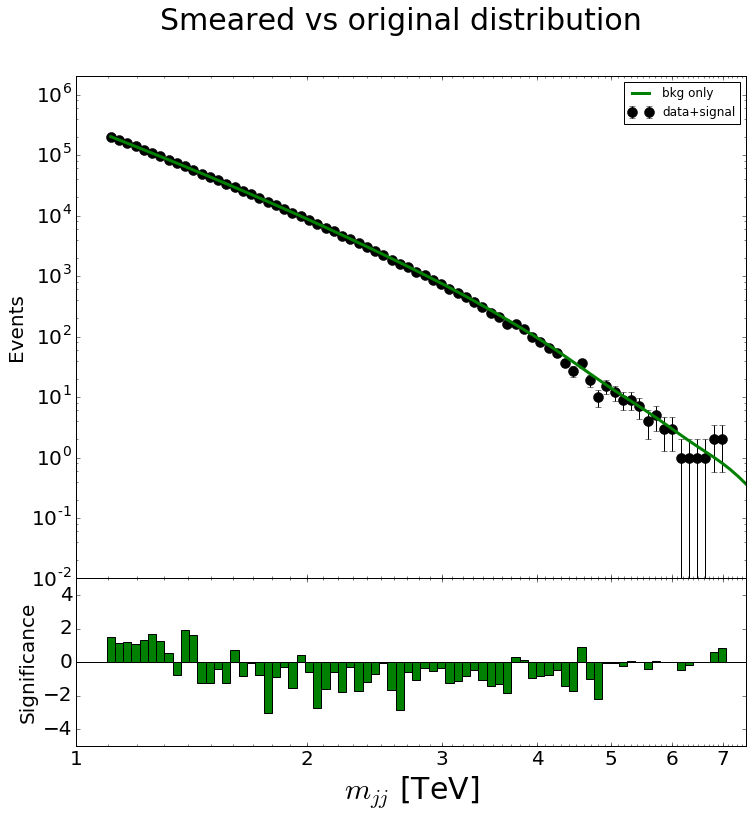

In [31]:
makePrettyPlots(xbins_smeared, ycounts_truth[start_bin:],smeared_counts, "Smeared vs original distribution")

#### Compare smeared distrubtion to fit function

In [32]:
def model_5param(t): 
    #because I already fit the 13TeV 3.6 fb-1 dijet dataset and here were the parameters
    p0, p1, p2, p3, p4 = (0.25, 9.8, -3.5, 0.61, 0.078)
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*np.append(np.diff(t), np.diff(t)[-1])

chi2 82.0383215228


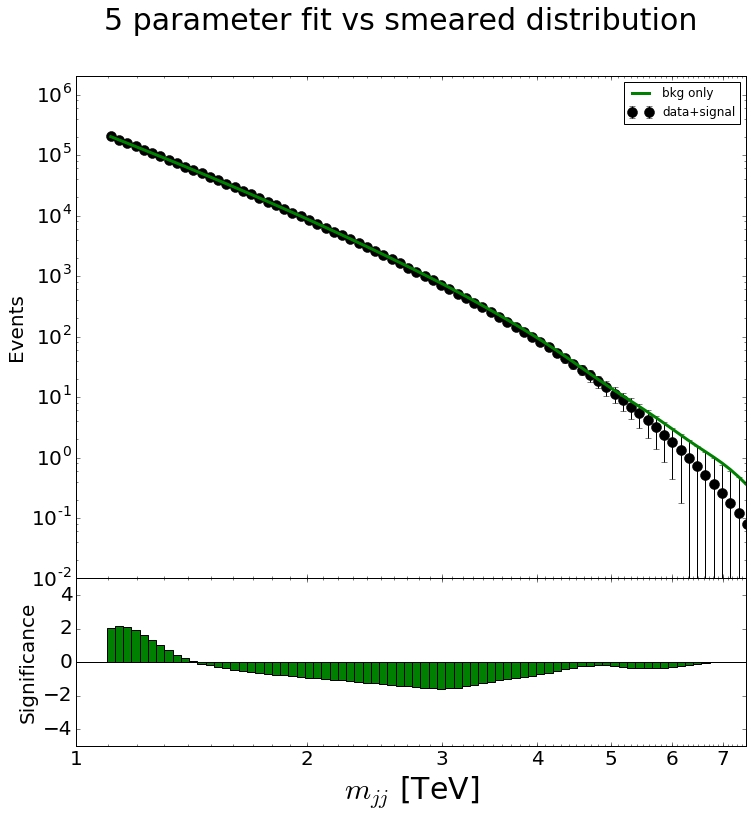

In [33]:
makePrettyPlots(xbins_smeared, model_5param(xbins_smeared), smeared_counts, "5 parameter fit vs smeared distribution")

#### Draw plots for one truth sample; draw histogram of pulls

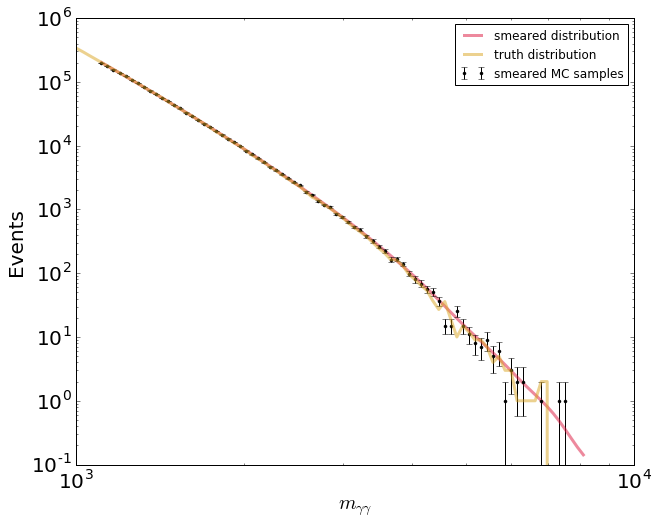

In [34]:
plot_truth(smeared_counts, noisy_smeared_counts, ycounts_truth)

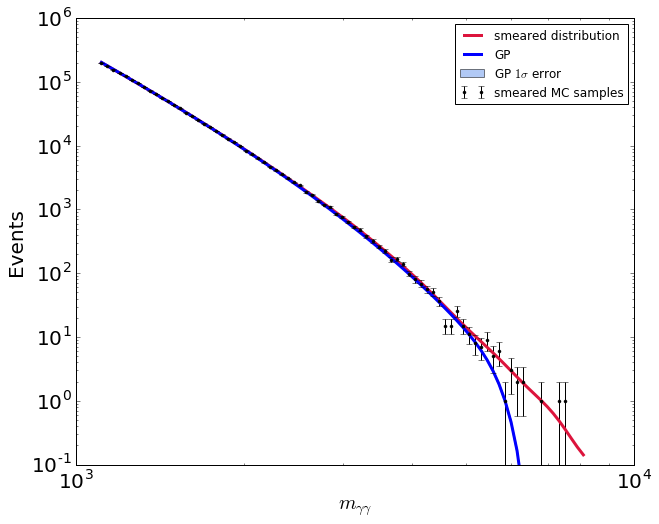

In [35]:
plot_GP(smeared_counts, noisy_smeared_counts, MAP_GP, std_GP)

#### save a bunch of variations of the smeared distribution as toys

In [28]:
toys=[]
for i in range(10000):
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    toys.append(noisy_smeared_counts)
toys=np.array(toys)
np.save("inputs/toys.npy", toys)